# Agrupamiento de clientes con Machine Learning no Supervisado


## AA2 – Modelado con K-Means

###  Propósito
Aplicar el algoritmo K-Means para agrupar clientes a partir de variables numéricas, seleccionando el número óptimo de clústeres mediante el método del codo, normalizando los datos y analizando los centroides obtenidos


### 1. Introducción

En esta segunda fase se desarrollará la aplicación del algoritmo **K-Means** para segmentar clientes del dataset [`Mall_Customers.csv`](https://drive.google.com/file/d/1f5B2kMAA7MY33-r1dyko5NYCkEXLNRda/view?usp=drive_link).  
Se busca encontrar patrones o grupos similares (clústeres) a partir de sus características de edad, ingreso anual y puntuación de gasto.  
El enfoque se basa en aprendizaje automático no supervisado.


###  Importación de librerías

In [1]:
# Importamos las librerías necesarias para análisis, escalamiento y modelado
import pandas as pd                       # Para manejo de datos en tablas (DataFrames)
import numpy as np                        # Para cálculos numéricos y arreglos
import matplotlib.pyplot as plt           # Para gráficos básicos
import seaborn as sns                     # Para visualizaciones estadísticas
from sklearn.cluster import KMeans        # Algoritmo K-Means de aprendizaje no supervisado
from sklearn.preprocessing import StandardScaler  # Para normalización de datos

### Carga del conjunto de datos desde Google Drive

In [2]:
# Cargar el archivo directamente desde Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticamos al usuario para acceder a Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Descargamos el archivo por su ID (ya compartido)
file_id = '1f5B2kMAA7MY33-r1dyko5NYCkEXLNRda'
archivo = drive.CreateFile({'id': file_id})
archivo.GetContentFile('Mall_Customers.csv')

# Cargamos el archivo en un DataFrame
df = pd.read_csv('Mall_Customers.csv')

# Mostramos las primeras filas para confirmar que se cargó correctamente
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Preparación de datos

In [3]:
# Eliminamos columnas que no son útiles para el modelo K-Means
# 'CustomerID' es un identificador único, y 'Gender' es una variable categórica
df_modelo = df.drop(['CustomerID', 'Gender'], axis=1)

# Mostramos las primeras filas del nuevo conjunto de datos
df_modelo.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


### Escalamiento de los datos

In [4]:
# Creamos un objeto para escalar (normalizar) los datos
escalador = StandardScaler()

# Ajustamos y transformamos los datos para que todas las variables tengan media = 0 y desviación estándar = 1
datos_escalados = escalador.fit_transform(df_modelo)

# Convertimos el resultado a DataFrame para poder visualizarlo con nombres de columnas
df_escalado = pd.DataFrame(datos_escalados, columns=df_modelo.columns)
df_escalado.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


### Selección del número óptimo de clústeres (K) usando el método del codo

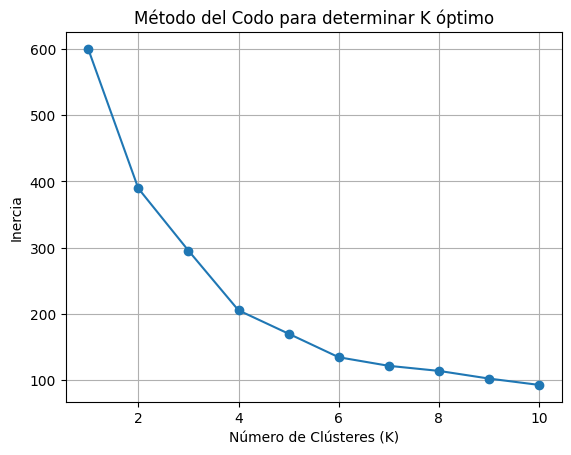

In [5]:
# Inicializamos una lista para guardar los valores de inercia (suma de errores cuadráticos)
inercia = []

# Probamos valores de K desde 1 hasta 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_escalado)
    inercia.append(kmeans.inertia_)

# Graficamos los resultados para observar el "codo"
plt.plot(range(1, 11), inercia, marker='o')
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

### Entrenamiento del modelo K-Means

In [6]:
# Seleccionamos el número de clústeres (por ejemplo, K=5 según el codo)
k = 5
modelo_kmeans = KMeans(n_clusters=k, random_state=42)

# Entrenamos el modelo con los datos escalados
modelo_kmeans.fit(df_escalado)

# Asignamos los clústeres obtenidos a una nueva columna en el DataFrame original
df['Cluster'] = modelo_kmeans.labels_

# Mostramos las primeras filas con la etiqueta del clúster asignado
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,3
3,4,Female,23,16,77,2
4,5,Female,31,17,40,2


### Visualización de los centroides

In [7]:
# Obtenemos los centroides de los clústeres (en espacio escalado)
centroides_escalados = modelo_kmeans.cluster_centers_

# Reescalamos los centroides a su forma original para interpretarlos mejor
centroides_originales = escalador.inverse_transform(centroides_escalados)

# Creamos un DataFrame para ver los valores centrales de cada clúster
df_centroides = pd.DataFrame(centroides_originales, columns=df_modelo.columns)
df_centroides

,Age,Annual Income (k$),Spending Score (1-100)
0,55.275862,47.620690,41.706897
1,32.875000,86.100000,81.525000
2,25.769231,26.115385,74.846154
3,26.733333,54.311111,40.911111
4,44.387097,89.774194,18.483871


### Predicción de una nueva muestra

In [8]:
# Definimos una nueva muestra ficticia (edad, ingreso, puntaje de gasto)
nueva_muestra = pd.DataFrame({
    'Age': [35],
    'Annual Income (k$)': [75],
    'Spending Score (1-100)': [60]
})

# Escalamos la muestra usando el mismo escalador
muestra_escalada = escalador.transform(nueva_muestra)

# Predecimos a qué clúster pertenece esta muestra
cluster_predicho = modelo_kmeans.predict(muestra_escalada)

print(f"La nueva muestra pertenece al clúster: {cluster_predicho[0]}")

La nueva muestra pertenece al clúster: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


### Visualización de clústeres

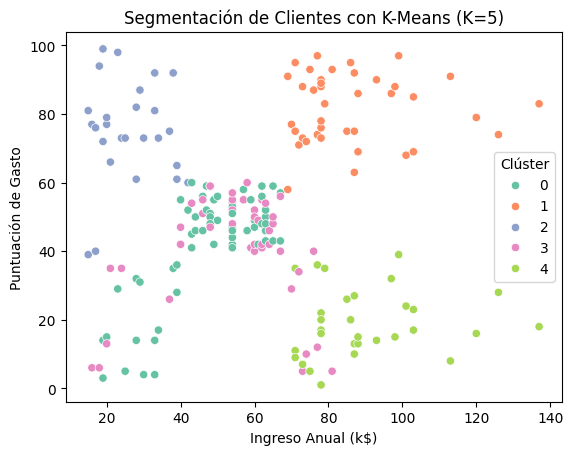

In [9]:
# Visualización en 2D usando las variables más representativas: Ingreso vs Puntuación de Gasto
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette='Set2',
    data=df
)
plt.title('Segmentación de Clientes con K-Means (K=5)')
plt.xlabel('Ingreso Anual (k$)')
plt.ylabel('Puntuación de Gasto')
plt.legend(title='Clúster')
plt.show()

## Conclusiones del Modelado

    -> El algoritmo K-Means agrupó a los clientes en 5 segmentos, según sus características numéricas.

    -> Cada clúster representa un perfil distinto de consumidor.

    -> El modelo puede predecir el clúster de nuevos casos con base en sus atributos.

    -> Esta segmentación puede ser usada en estrategias de marketing, fidelización y ventas.


En la siguiente fase, se interpretarán gráficamente los clústeres obtenidos y se evaluará el impacto del número K en los resultados.
